 # moving average cross

In [1]:
import pandas as pd
import numpy as np

def load_financial_data(start_date, end_date):
    df = pd.read_json("../data/example00593.json", orient='series')
    df = df.set_index('date')
    df = df.loc[start_date:end_date]
    return df

In [19]:
def double_moving_average(financial_data, short_window, long_window):
    signals = pd.DataFrame(index=financial_data.index)
    signals['signal'] = 0.0
    signals['short_mavg'] =financial_data['close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = financial_data['close'].rolling(window=long_window, min_periods=1, center=False).mean()
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] < signals['long_mavg'][short_window:], 1.0, 0.0)
    signals['orders'] = signals['signal'].diff()
    return signals

s_data = load_financial_data('2021-01-01', '2023-03-15')
ts = double_moving_average(s_data, 20, 100)

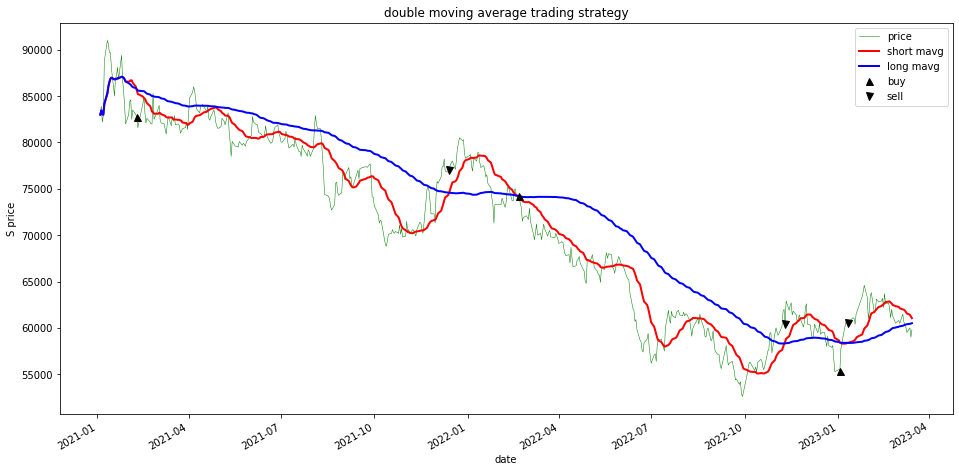

In [20]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111, ylabel='S price')
s_data['close'].plot(ax=ax1, color='g', lw=.5)
ts['short_mavg'].plot(ax=ax1, color='r', lw=2.)
ts['long_mavg'].plot(ax=ax1, color='b', lw=2.)

ax1.plot(ts.loc[ts.orders==1.0].index, s_data['close'][ts.orders==1.0], '^', markersize=7, color='k')
ax1.plot(ts.loc[ts.orders==-1.0].index, s_data['close'][ts.orders==-1.0], 'v', markersize=7, color='k')
plt.legend(["price", "short mavg", "long mavg", "buy", "sell"])
plt.title("double moving average trading strategy")
plt.show()

# naive 

In [24]:
def naive_momentum_trading(financial_data, nb_conseq_days):
    signals = pd.DataFrame(index=financial_data.index)
    signals['orders'] = 0
    cons_day = 0
    prior_price = 0
    init = True
    for k in range(len(financial_data['close'])):
        price = financial_data['close'][k]
        if init:
            prior_price = price
            init = False
        elif price > prior_price:
            if cons_day < 0:
                cons_day = 0
            cons_day+=1
        elif price < prior_price:
            if cons_day > 0:
                cons_day=0
            cons_day-=1
        if cons_day==nb_conseq_days:
            signals['orders'][k] = 1
        elif cons_day == -nb_conseq_days:
            signals['orders'][k] = -1
    return signals
ts = naive_momentum_trading(s_data, 5)

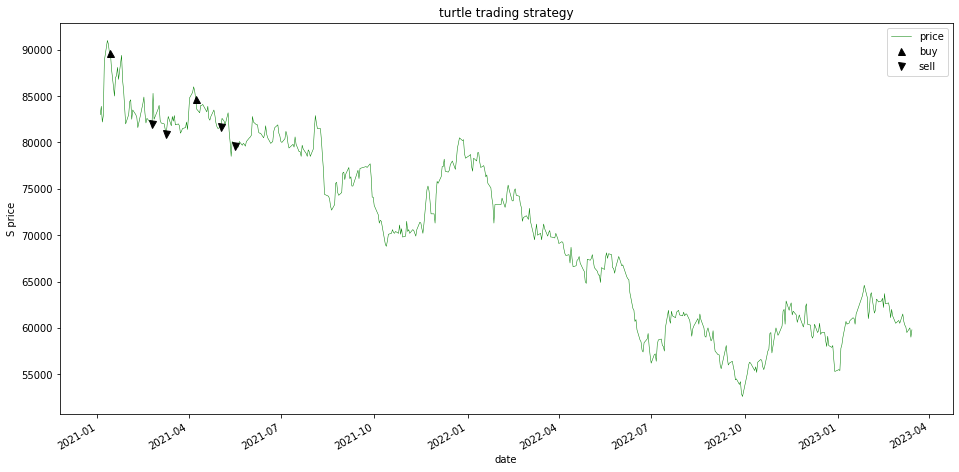

In [26]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111, ylabel='S price')
s_data['close'].plot(ax=ax1, color='g', lw=.5)

ax1.plot(ts.loc[ts.orders==1.0].index, s_data['close'][ts.orders==1.0], '^', markersize=7, color='k')
ax1.plot(ts.loc[ts.orders==-1.0].index, s_data['close'][ts.orders==-1.0], 'v', markersize=7, color='k')
plt.legend(["price", "buy", "sell"])
plt.title("naive trading strategy")
plt.show()

# turtle

In [31]:
def turtle_trading(financial_data, window_size):
    signals = pd.DataFrame(index=financial_data.index)
    signals['orders'] = 0
    signals['high'] =financial_data['close'].shift(1).rolling(window=window_size).max()
    signals['low'] = financial_data['close'].shift(1).rolling(window=window_size).min()
    signals['avg'] = financial_data['close'].shift(1).rolling(window=window_size).mean()
    signals['long_entry'] = financial_data['close'] > signals.high
    signals['short_entry'] = financial_data['close'] < signals.low
    signals['long_exit'] = financial_data['close'] < signals.avg
    signals['short_exit'] = financial_data['close'] > signals.avg
    init = True
    position = 0
    for k in range(len(signals)):
        if signals['long_entry'][k] and position == 0:
            signals.orders.values[k] = 1
            position = 1
        elif signals['short_entry'][k] and position == 0:
            signals.orders.values[k] = -1
            position = -1
        elif signals['short_exit'][k] and position > 0:
            signals.orders.values[k] = -1
            position = 0
        elif signals['long_exit'][k] and position < 0:
            signals.orders.values[k] = 1
            position = 0
        else:
            signals.orders.values[k] = 0
    return signals
ts = turtle_trading(s_data, 50)

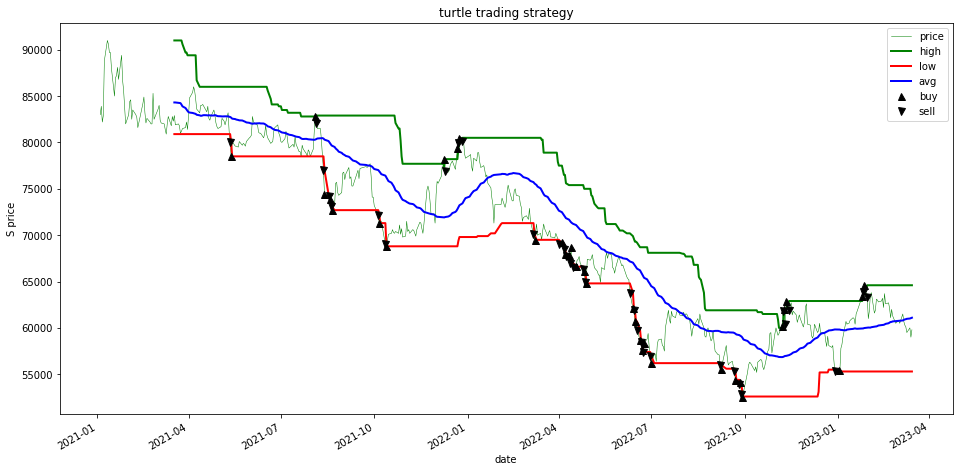

In [32]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111, ylabel='S price')
s_data['close'].plot(ax=ax1, color='g', lw=.5)
ts['high'].plot(ax=ax1, color='g', lw=2.)
ts['low'].plot(ax=ax1, color='r', lw=2.)
ts['avg'].plot(ax=ax1, color='b', lw=2.)

ax1.plot(ts.loc[ts.orders==1.0].index, s_data['close'][ts.orders==1.0], '^', markersize=7, color='k')
ax1.plot(ts.loc[ts.orders==-1.0].index, s_data['close'][ts.orders==-1.0], 'v', markersize=7, color='k')
plt.legend(["price", "high", "low", "avg", "buy", "sell"])
plt.title("turtle trading strategy")
plt.show()